## 実習3-3
### CIFER-10をCNNで分類する。
### 目的:Data Augmentationによる精度上昇を確認

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator #data augmentationするため
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
import os
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
batch_size = 50
num_classes = 10
epochs = 10
data_augmentation = True #data augmentationを実行するときはTrueに設定

In [3]:
# イメージサイズの設定
img_rows, img_cols = 32, 32

In [4]:
# CIFAR-10データをダウンロード。既に訓練データとテストデータに分割されている。
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 2s 0us/step
50000 train samples
10000 test samples


In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 1)
#"channels_first"の場合、入力のshapeは(batch, channels, row, column)となり,
#"channels_last"の場合，入力のshapeは(batch, row, column, channels)となります。

In [6]:
#学習用の画像とラベル
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

#テスト用の画像とラベル
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


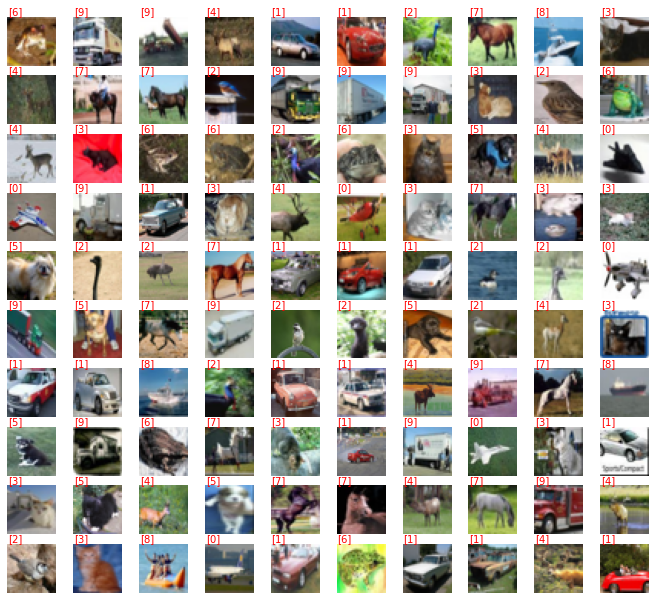

In [7]:
#10x10でラベルと画像を同時に表示
for i in range(100):
    plt.subplot(10,10,i + 1)
    plt.axis("off")
    plt.imshow(x_train[i,:32,:32])
    plt.text(0, -2, y_train[i], fontsize=10, color='red') #ラベルの数字の設定
    plt.subplots_adjust(left=0, right=1.5, top=2, bottom=0) #画像間のマージンを設定
plt.show()

In [8]:
#各数字がそれぞれ何個ずつあるかカウント(データ数に偏りがないことを確認)
a, b = np.unique(y_train, return_counts=True)
c, d = np.unique(y_test, return_counts=True)
print(dict(zip(a, b)))
print(dict(zip(c, d)))

"""
0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'
"""

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


"\n0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'\n"

In [9]:
# 教師データ(y_train, y_test)をOne hotなベクトルへ変換する
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
#One hotベクトルになっていることを確認
Y_train[0:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
#データの値を正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [12]:
#CNNのモデル/構造
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()#モデルの内容を表示

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [13]:
# RMSprop optimizerの初期化
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)


In [14]:
# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [15]:
# 計算開始
start = time.time() #処理を始めた時間を記録
if not data_augmentation:
    print('Not using data augmentation.')
    hist = model.fit(x_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # 以下でData Augmentationを行う:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # サンプル平均を0にする。
        featurewise_std_normalization=False,  # サンプルを標準偏差で割る。
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # ZCA白色化
        rotation_range=0,  # 画像を指定の角度でランダムに回転させる
        width_shift_range=0.1,  # 画像を水平方向にランダムに移動する。 (0-1,1は画像サイズを基準にしている)
        height_shift_range=0.1,  # 画像を垂直方向にランダムに移動する。 (0-1,1は画像サイズを基準にしている)
        horizontal_flip=True,  # 画像を水平方向にランダムに反転する。
        vertical_flip=False)  # 画像を垂直方向にランダムに反転する。
    
#  特徴ごとの正規化に必要な量を計算する
#（ZCAホワイトニングの標準、平均、および主成分が適用される）
    datagen.fit(x_train)

    # datagen.flow()によって前処理されたbatchを使うときはmodel.fit_generatorを用いる
    hist = model.fit(datagen.flow(x_train, Y_train,
                                batch_size=batch_size),
                                steps_per_epoch = 50000/batch_size, #1epochで用いるminibatchの数
                                epochs=epochs,
                                validation_data=(x_test, Y_test),
                                workers=4,
                                )

elapsed_time = time.time() - start #(処理時間)＝(処理が終わった時間)ー(処理を始めた時間)
print("計算時間:",elapsed_time,"秒") 

# lossとAccuracyを出す
scores = model.evaluate(x_test, Y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/10
1000/1000 [==============================] - 36s 29ms/step - loss: 2.0674 - accuracy: 0.2290 - val_loss: 1.6379 - val_accuracy: 0.4121
Epoch 2/10
1000/1000 [==============================] - 29s 29ms/step - loss: 1.6954 - accuracy: 0.3788 - val_loss: 1.4461 - val_accuracy: 0.4855
Epoch 3/10
1000/1000 [==============================] - 28s 28ms/step - loss: 1.5542 - accuracy: 0.4336 - val_loss: 1.3482 - val_accuracy: 0.5149
Epoch 4/10
1000/1000 [==============================] - 29s 29ms/step - loss: 1.4617 - accuracy: 0.4729 - val_loss: 1.3058 - val_accuracy: 0.5308
Epoch 5/10
1000/1000 [==============================] - 28s 28ms/step - loss: 1.3823 - accuracy: 0.5019 - val_loss: 1.2595 - val_accuracy: 0.5536
Epoch 6/10
1000/1000 [==============================] - 29s 29ms/step - loss: 1.3190 - accuracy: 0.5289 - val_loss: 1.2578 - val_accuracy: 0.5480
Epoch 7/10
1000/1000 [==============================] - 28s 28ms/step - loss: 1.2721 - ac

In [16]:
# モデルと重みの保存
save_dir = os.path.join(os.getcwd(), 'saved_models') #os.path.join(a,b)でa/bのようにパスを作る。os.getwed()はカレントディレクトリ
model_name = 'keras_cifar10_trained_model.h5'

if not os.path.isdir(save_dir):#'saved_models'というフォルダが無ければ作る
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)#保存先のパスを指定
model.save(model_path)#モデルの保存
print('Saved trained model at %s ' % model_path)


Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


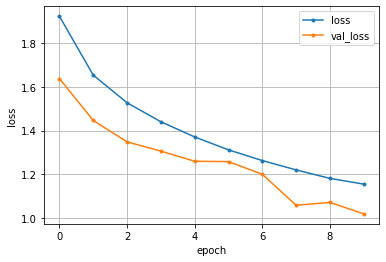

In [17]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

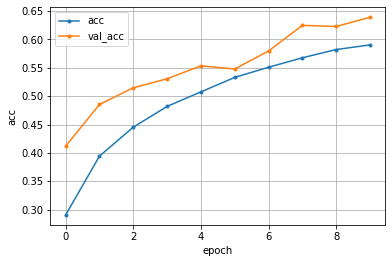

In [18]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# accuracyのグラフ
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [19]:
# CNNの予測値を出力
preds = model.predict(x_test) #softmax後の数値を出力
cls = model.predict_classes(x_test) #予測したクラスを出力
print(preds[0:5])
print(cls[0:5])
print(y_test[0:5]) #予測クラスと教師を比較

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[4.55796812e-03 1.60875847e-03 3.08981203e-02 4.06424850e-01
  1.89316757e-02 4.74620253e-01 3.34765464e-02 1.34816775e-02
  1.33480066e-02 2.65226047e-03]
 [7.88447484e-02 1.18411191e-01 1.12154979e-04 1.60603795e-05
  2.18407840e-05 4.13731414e-07 3.55597626e-06 1.65193455e-06
  7.91796327e-01 1.07919928e-02]
 [7.60638565e-02 3.50403160e-01 1.87422277e-03 2.05813558e-03
  2.16787052e-03 4.19071992e-04 4.10782435e-04 8.26256466e-04
  4.12324160e-01 1.53452471e-01]
 [3.72177601e-01 9.53161642e-02 5.78649575e-03 7.12379231e-04
  2.47284560e-03 5.92657998e-05 4.79281764e-04 3.90567235e-04
  4.99137163e-01 2.34682243e-02]
 [2.29488232e-05 8.65485854e-05 1.39344027e-02 3.69684026e-02
  2.13203683e-01 4.29979526e-03 7.31114447e-01 2.29011275e-04
  4.49559229e-05 9.57763477e-05]]
[5 8 8 8 6]
[[3]
 [8]
 [8]
 [0]
 [6]]


### 課題3-3-1
#### Data Augmentationの使用前後でaccuracyが上昇することを確認してください。